In [0]:
!nvidia-smi

Sat May 23 16:15:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip --quiet install transformers
!pip --quiet install tokenizers

     |████████████████████████████████| 665kB 8.5MB/s 
     |████████████████████████████████| 890kB 23.9MB/s 
     |████████████████████████████████| 3.8MB 17.3MB/s 
     |████████████████████████████████| 1.1MB 54.1MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Scripts/.' .

In [0]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/'
MODEL_BASE_PATH = COLAB_BASE_PATH + 'Models/Files/177-roBERTa_base/'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [0]:
import json, warnings, shutil
from scripts_step_lr_schedulers import *
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [0]:
# Unzip files
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_96/fold_1.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_96/fold_2.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_96/fold_3.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_96/fold_4.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_96/fold_5.tar.gz'

In [0]:
database_base_path = COLAB_BASE_PATH + 'Data/complete_96/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

,textID,text,selected_text,sentiment,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,7,10,35,7,10,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,10,13,8,2,3,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,5,6,11,2,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,5,6,14,3,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,74,14,17,13,3,4,train,train,validation,train,train


# Model parameters

In [0]:
vocab_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-vocab.json'
merges_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-merges.txt'
base_path = COLAB_BASE_PATH + 'qa-transformers/roberta/'

config = {
  "MAX_LEN": 96,
  "BATCH_SIZE": 32,
  "EPOCHS": 4,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": 4,
  "question_size": 4,
  "N_FOLDS": 5,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [0]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)

## Learning rate schedule

Learning rate schedule: 3e-05 to 3e-05 to 1e-06


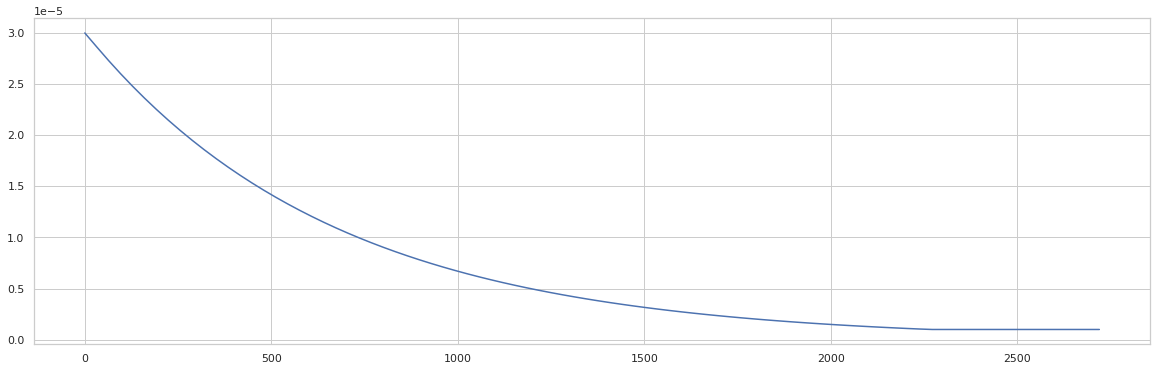

In [0]:
lr_min = 1e-6
lr_max = config['LEARNING_RATE']
train_size = len(k_fold[k_fold['fold_1'] == 'train'])
step_size = train_size // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
decay = .9985

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps=1, lr_start=lr_max, lr_max=lr_max, lr_min=lr_min, decay=decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [0]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _ = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})

    x = layers.Dropout(.1)(last_hidden_state) 
    x = layers.Dense(1)(x)
    x = layers.Flatten()(x)
    y = layers.Activation('sigmoid', name='y_span')(x)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=y)
    
    return model

In [0]:
def get_training_dataset(x_train, y_train, batch_size, buffer_size, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_train[0], 'attention_mask': x_train[1]}, 
                                                  {'y_span': y_train}))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_validation_dataset(x_valid, y_valid, batch_size, buffer_size, repeated=False, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_valid[0], 'attention_mask': x_valid[1]}, 
                                                  {'y_span': y_valid}))
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_test_dataset(x_test, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices({'input_ids': x_test[0], 'attention_mask': x_test[1]})
    dataset = dataset.batch(batch_size)
    return dataset

In [0]:
threshold = .5
get_start = lambda x: np.where(x > threshold)[0][0] if (len(np.where(x > threshold)[0]) > 0) else 0
get_end = lambda x: np.where(x > threshold)[0][-1] if (len(np.where(x > threshold)[0]) > 0) else config['MAX_LEN']

def re_scale(y):
    y = y / np.max(y)
    
    return y.astype(int)

def predict_eval_df(df, model, x_train, x_valid, dataset_fn, decode_fn, n_fold, tokenizer, config, question_size=None):
    train_preds = model.predict(dataset_fn(x_train, config['BATCH_SIZE']))
    valid_preds = model.predict(dataset_fn(x_valid, config['BATCH_SIZE']))
    
    df.loc[df['fold_%d' % (n_fold)] == 'train', 'start_fold_%d' % (n_fold)] = np.apply_along_axis(get_start, -1, train_preds)
    df.loc[df['fold_%d' % (n_fold)] == 'train', 'end_fold_%d' % (n_fold)] = np.apply_along_axis(get_end, -1, train_preds)
    df.loc[df['fold_%d' % (n_fold)] == 'validation', 'start_fold_%d' % (n_fold)] = np.apply_along_axis(get_start, -1, valid_preds)
    df.loc[df['fold_%d' % (n_fold)] == 'validation', 'end_fold_%d' % (n_fold)] = np.apply_along_axis(get_end, -1, valid_preds)
    
    df['end_fold_%d' % (n_fold)] = df['end_fold_%d' % (n_fold)].astype(int)
    df['start_fold_%d' % (n_fold)] = df['start_fold_%d' % (n_fold)].astype(int)
    df['end_fold_%d' % (n_fold)].clip(0, df['text_len'], inplace=True)
    df['start_fold_%d' % (n_fold)].clip(0, df['end_fold_%d' % (n_fold)], inplace=True)
    if question_size is None:
        df['prediction_fold_%d' % (n_fold)] = df.apply(lambda x: decode_fn(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], 
                                                                           x['text'], config['question_size'], tokenizer), axis=1)
    else:
        df['prediction_fold_%d' % (n_fold)] = df.apply(lambda x: decode_fn(x['start_fold_%d' % (n_fold)], x['end_fold_%d' % (n_fold)], 
                                                                           x['text'], config['question_size'], tokenizer), axis=1)
    df['prediction_fold_%d' % (n_fold)].fillna(df['text'], inplace=True)
    df['jaccard_fold_%d' % (n_fold)] = df.apply(lambda x: jaccard(x['selected_text'], x['prediction_fold_%d' % (n_fold)]), axis=1)

# Train

In [0]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
k_fold_best = k_fold.copy()
history_list = []


for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))

    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')

    # Transform labels
    y_train = np.apply_along_axis(re_scale, -1, np.sum(y_train, axis=0))
    y_valid = np.apply_along_axis(re_scale, -1, np.sum(y_valid, axis=0))
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    valid_step_size = x_valid.shape[1] // config['BATCH_SIZE']

    # Build TF datasets
    train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED))
    valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=True, seed=SEED))
    train_data_iter = iter(train_dist_ds)
    valid_data_iter = iter(valid_dist_ds)
    
    # Step functions
    @tf.function
    def train_step(data_iter):
        def train_step_fn(x, y):
            with tf.GradientTape() as tape:
                probabilities = model(x, training=True)
                loss = loss_fn(y['y_span'], probabilities)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # update metrics
            train_loss.update_state(loss)
        for _ in tf.range(step_size):
            strategy.experimental_run_v2(train_step_fn, next(data_iter))

    @tf.function
    def valid_step(data_iter):
        def valid_step_fn(x, y):
            probabilities = model(x, training=False)
            loss = loss_fn(y['y_span'], probabilities)
            # update metrics
            valid_loss.update_state(loss)
        for _ in tf.range(valid_step_size):
            strategy.experimental_run_v2(valid_step_fn, next(data_iter))

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    optimizer = optimizers.Adam(learning_rate=lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), warmup_steps=1, 
                                                                                       lr_start=lr_max, lr_max=lr_max, lr_min=lr_min, decay=decay))
    loss_fn = losses.binary_crossentropy
    train_loss = metrics.Sum()
    valid_loss = metrics.Sum()
        
    metrics_dict = {'loss': train_loss, 'val_loss': valid_loss}
        
    history = custom_fit(model, metrics_dict, train_step, valid_step, train_data_iter, valid_data_iter, 
                         step_size, valid_step_size, config['BATCH_SIZE'], config['EPOCHS'], config['ES_PATIENCE'], 
                         (MODEL_BASE_PATH + model_path), save_last=False)
    
    history_list.append(history)
    model.save_weights(MODEL_BASE_PATH +'last_' + model_path)
    
    # Make predictions (last model)
    x_train = np.load(base_data_path + 'x_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    predict_eval_df(k_fold, model, x_train, x_valid, get_test_dataset, decode, n_fold, tokenizer, config, config['question_size'])

    # Make predictions (best model)
    model.load_weights(MODEL_BASE_PATH + model_path)
    predict_eval_df(k_fold_best, model, x_train, x_valid, get_test_dataset, decode, n_fold, tokenizer, config, config['question_size'])


FOLD: 1
Train for 687 steps, validate for 171 steps

EPOCH 1/4
time: 274.9s loss: 0.0346 val_loss: 0.0247
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/177-roBERTa_base/model_fold_1.h5"

EPOCH 2/4
time: 267.4s loss: 0.0253 val_loss: 0.0233
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/177-roBERTa_base/model_fold_1.h5"

EPOCH 3/4
time: 267.8s loss: 0.0241 val_loss: 0.0233

EPOCH 4/4
time: 264.2s loss: 0.0235 val_loss: 0.0231
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/177-roBERTa_base/model_fold_1.h5"
Training finished

FOLD: 2
Train for 687 steps, validate for 171 steps

EPOCH 1/4
time: 275.2s loss: 0.0355 val_loss: 0.0254
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Models/Files/177-roBERTa_base/model_fold_2.h5"

EPOCH 2/4
time: 265.4s loss: 0.0241 val_loss: 0.0240


# Model loss graph

Fold: 1


AttributeError: ignored

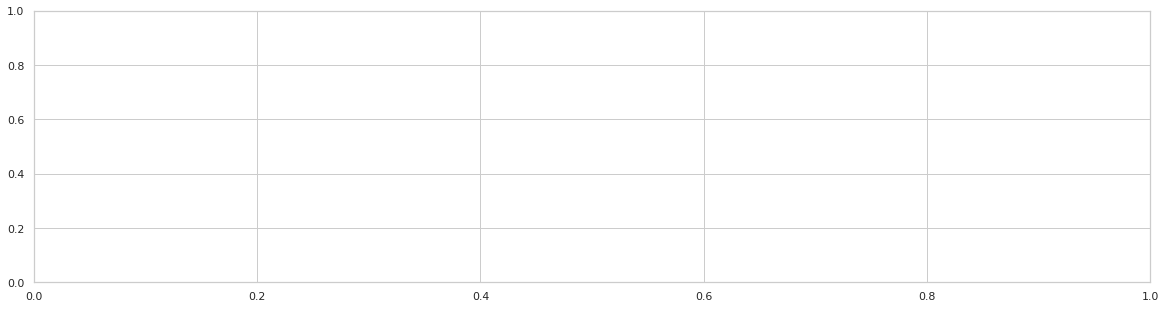

In [0]:
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation (best model)

In [0]:
display(evaluate_model_kfold(k_fold_best, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.643046,0.631736,0.011309,0.629503,0.624996,0.653136,0.634257,0.646320,0.639198,0.640339,0.617856,0.645930,0.642374
Sentiment negative,0.409118,0.390861,0.018257,0.400138,0.378677,0.425327,0.402373,0.411411,0.403175,0.401602,0.371926,0.407112,0.398153
Sentiment neutral,0.956076,0.955667,0.000409,0.944363,0.942850,0.959544,0.953311,0.963545,0.965533,0.952644,0.951449,0.960283,0.965192
Sentiment positive,0.449645,0.430515,0.019130,0.429641,0.436399,0.462812,0.431014,0.448342,0.430599,0.452209,0.408822,0.455222,0.445743
0 <= text wordCnt < 3,0.850794,0.849826,0.000968,0.853147,0.839552,0.848949,0.839956,0.856074,0.863517,0.854545,0.836538,0.841256,0.869565
3 <= text wordCnt < 10,0.725482,0.715253,0.010229,0.722732,0.695540,0.728364,0.726550,0.725729,0.728481,0.723613,0.701076,0.726970,0.724618
10 <= text wordCnt < 30,0.591934,0.579735,0.012199,0.572668,0.578835,0.605396,0.580787,0.596079,0.586337,0.589104,0.563556,0.596421,0.589158
30 <= text wordCnt < 100,0.524136,0.513559,0.010577,0.476609,0.525196,0.602222,0.396564,0.540898,0.463542,0.514316,0.511638,0.486635,0.670854
0 <= selected text wordCnt < 3,0.565197,0.540241,0.024956,0.546494,0.533263,0.583174,0.543766,0.565127,0.543306,0.573234,0.524678,0.557957,0.556193


# Model evaluation (last model)

In [0]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.641965,0.630244,0.011721,0.629503,0.624996,0.653136,0.634257,0.640919,0.631737,0.640339,0.617856,0.645930,0.642374
Sentiment negative,0.407717,0.388204,0.019513,0.400138,0.378677,0.425327,0.402373,0.404404,0.389890,0.401602,0.371926,0.407112,0.398153
Sentiment neutral,0.954613,0.954323,0.000290,0.944363,0.942850,0.959544,0.953311,0.956233,0.958816,0.952644,0.951449,0.960283,0.965192
Sentiment positive,0.449351,0.429887,0.019463,0.429641,0.436399,0.462812,0.431014,0.446871,0.427459,0.452209,0.408822,0.455222,0.445743
0 <= text wordCnt < 3,0.850679,0.848251,0.002428,0.853147,0.839552,0.848949,0.839956,0.855498,0.855643,0.854545,0.836538,0.841256,0.869565
3 <= text wordCnt < 10,0.724801,0.714025,0.010775,0.722732,0.695540,0.728364,0.726550,0.722324,0.722343,0.723613,0.701076,0.726970,0.724618
10 <= text wordCnt < 30,0.590667,0.578123,0.012545,0.572668,0.578835,0.605396,0.580787,0.589747,0.578278,0.589104,0.563556,0.596421,0.589158
30 <= text wordCnt < 100,0.516865,0.510410,0.006455,0.476609,0.525196,0.602222,0.396564,0.504545,0.447797,0.514316,0.511638,0.486635,0.670854
0 <= selected text wordCnt < 3,0.565069,0.539326,0.025743,0.546494,0.533263,0.583174,0.543766,0.564486,0.538732,0.573234,0.524678,0.557957,0.556193


# Visualize predictions

In [0]:
display(k_fold[[c for c in k_fold.columns if not (c.startswith('textID') or 
                                                  c.startswith('text_len') or 
                                                  c.startswith('selected_text_len') or 
                                                  c.startswith('text_wordCnt') or 
                                                  c.startswith('selected_text_wordCnt') or 
                                                  c.startswith('fold_') or 
                                                  c.startswith('start_fold_') or 
                                                  c.startswith('end_fold_'))]].head(15))

,text,selected_text,sentiment,jaccard,text_tokenCnt,selected_text_tokenCnt,prediction_fold_1,jaccard_fold_1,prediction_fold_2,jaccard_fold_2,prediction_fold_3,jaccard_fold_3,prediction_fold_4,jaccard_fold_4,prediction_fold_5,jaccard_fold_5
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,10,10,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000,"i`d have responded, if i were going",1.000000
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,13,3,sad,0.500000,sad,0.500000,sad,0.500000,sad,0.500000,sad,0.500000
2,my boss is bullying me...,bullying me,negative,0.166667,6,2,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333,bullying me...,0.333333
3,what interview! leave me alone,leave me alone,negative,0.600000,6,3,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000,leave me alone,1.000000
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,17,4,"****,",0.333333,"sons of ****,",1.000000,"sons of ****,",1.000000,"sons of ****,",1.000000,"sons of ****,",1.000000
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,1.000000,27,27,earth,0.083333,http://www.dothebouncy.com/smf - some shameles...,1.000000,http://www.dothebouncy.com/smf - some shameles...,1.000000,earth,0.083333,earth,0.083333
6,2am feedings for the baby are fun when he is a...,fun,positive,0.071429,17,1,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000,fun,1.000000
7,soooo high,soooo high,neutral,1.000000,3,3,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000,soooo high,1.000000
8,both of you,both of you,neutral,1.000000,3,3,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000,both of you,1.000000
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,0.500000,19,7,that possible!?),0.000000,wow... u just became cooler.,1.000000,wow... u just became cooler.,1.000000,wow,0.000000,wow...,0.200000
